# Analysis and prediction of Crime data as it relates to weather conditions in the city of San Francisco

- Jim Haskin

- GA-Data Science
- Dec 2015

- 2/17/2016

## Hypothisis
It is often said that people lose their temper more when it is hot out and that all the crazies come out when there is a full moon. But does the data prove these hunches are true? 
If it is true, can we look at the weather forcast for the next week and predict if the number or intensity of Police Incidents will be higher or lower than usual?

## Method
Crime Data
- I have collected the incident reports of the San Franciso Police Department from the SF OpenData website. https://data.sfgov.org/data?category=Public%20Safety. I have the records from January, 2003 until the beginning of 2016.
- I summerized the report to generate a daily report of the number of incidents and another factor I am calling Crime Level. Each incident is given a score based on how violent it is. Murders and assaults are rated high. Traffic violations and non-criminal incidents are rated low. These scores are summed and then normalized to a scale of 0 - 10.
- This was done in the `'2_clean_data_sf_crime'` notebook.
- Data written to file. `'sf_crime_clean.csv'`

Weather Data
- I collected historical weather data for the San Franciso area from January 2003 until December 2015. The data comes from Weather Underground. http://www.wunderground.com/history/
- To that data I added new features, such as the phase of the moon, that I wanted to investigate.
- This was done in the `'3_clean_weather_combine_with_crime'` notebook.
- Data written to file. `'sf_crime_weather.csv'`

Analysis and Modeling
- I looked at the crime levels as it related to different features to get a general idea of what features are important.
- Removed fields that are not in the Forecast Data that will be used for prediction.
- Build Model.......
- ...........

Prediction
- I used the WeatherUnderground API and the OpenWeatherMap API to retreive the forecast for the next 10 days in San Fransico.
- To this I added in the other relavent features such as Moon Phase.
- This is done in the `'8_get_weather_forcast'` notebook.
- Data is written to file. `'forecast_10day.csv'`
- This new data is then run throught the model to predict the general level of crime for the next 10 days.

## Sections

- [Data Source Definition](#Data-source-Definition)
- [Prepare Data](#Prepare-Data)
- - [Catagoricals](#Catagoricals)
- - [Select Features](#Select-Features)
- [Dummy Regressor](#Dummy-Regressor)
- [Random Forest](#Random-Forests)
- [SVM](#SVM)
- [Lasso/Ridge](#Lasso/Ridge)
- [knn](#knn)
- [Forecast](#Forecast)
- - [Add Engineered Features](#Add-Engineered-Features)
- - [Run Models on Prediction](#Run-Models-on-Prediction)
- [Results](#Results)
- [Change Log](#Change-Log)
- [To Try](#To-Try)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
# use fivethirtyeight style for all graphics
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVR
from sk_modelcurves.learning_curve import draw_learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error

## Data source Definition

[[back to top](#Sections)]


Data was consolidated in these two Notebooks
- 2_clean_data_sf_crime.ipynb | Data downloaded from SF Open Data site. 
- 3_clean_weather_combine_with_crime.ipynb | Data downloaded from WeatherUnderground.com
- Final file name 'sf_crime_weather.csv'


FieldName|Type|Description                             
---------------|------------|---------------------
Index:Date|DateTime|2003-01-01 to 2015-12-31
crime_level_sum|int64|Calculated Crime Level for the day
crime_level_count|int64|Number of incidents for the day
crime_level|float64|Crime level scaled to 0-10
dayofweek|object|Day of the week in string format
day|int64|Day of month in numeric
month|int64|Month of year in numeric
year|int64|Year in numeric
temp_max|int64|High Temperature for the day in degrees F
temp_mean|int64|Mean Temperature for the day in degrees F
temp_min|int64|Low Temperature for the day in degrees F
temp_delta|int64|Temperature change for the day in degrees F
dew_point_max|int64|High Dew Point for the day in degrees F
dew_point_mean|int64|Mean Dew Point for the day in degrees F
dew_point_min|int64|Low Dew Point for the day in degrees F
humidity_max|int64|Maximum Humidity for the day in percentage
humidity_mean|int64|Mean Humidity for the day in percentage
humidity_min|int64|Minimum Humidity for the day in percentage
sl_pressure_max|float64|High Sea Level for the day in inches
sl_pressure_mean|float64|Mean Sea Level for the day in inches
sl_pressure_min|float64|Low Sea Level for the day in inches
wind_speed_max|int64|Maximum maintained Wind Speed in mph
wind_speed_mean|int64|Mean maintained Wind Speed in mph
wind_max_gust|float64|Maximum Wind Gust in mph
precipitation|float64|Amount is precipitation in inches
cloud_cover|int64|Cloud Cover in percentage
events|object|Significant Events such as 'Rain', 'Fog'
wind_direction|int64|General wind direction, numeric 0 359
sun_length|float64|Number of minutes of Sun on day
moon_phase|float64|Phase moon is in. 0.5 = full moon
sun_units|float64|the minutes of Sun scaled by the cloud cover percentage

# Prepare Data

[[back to top](#Sections)]


## Read in combined Data 
    

In [3]:
data = pd.read_csv('sf_crime_weather.csv', index_col=0)
data.head(5)

,crime_level_sum,crime_level_count,weather_crime_sum,dayofweek,day,month,year,end_of_week,crime_level,weather_crime_level,...,events,wind_direction,rain,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
2003-01-01,1066,541,143,wednesday,1,1,2003,False,10.000000,8.717949,...,No,86,False,578.733333,0.950084,364.602000,48,52,160.246207,75.602722
2003-01-02,750,411,72,thursday,2,1,2003,False,4.903226,2.649573,...,No,79,False,579.400000,0.983944,220.172000,50,54,174.834219,79.559031
2003-01-03,799,440,84,friday,3,1,2003,True,5.693548,3.675214,...,No,56,False,580.100000,0.017763,290.050000,50,55,165.091411,77.938166
2003-01-04,674,347,65,saturday,4,1,2003,True,3.677419,2.051282,...,Fog,295,False,580.866667,0.051546,290.433333,52,57,203.511400,86.591989
2003-01-05,755,377,102,sunday,5,1,2003,False,4.983871,5.213675,...,Fog,22,False,581.700000,0.085328,290.850000,52,55,220.937501,89.274978


### Catagoricals

[[back to top](#Sections)]


In [4]:
#data['events'].fillna('No', inplace=True)
data['events'] = data['events'].astype('category')
data['day'] = data['day'].astype('category')
data['month'] = data['month'].astype('category')
data['year'] = data['year'].astype('category')
data['dayofweek'] = data['dayofweek'].astype('category')
data['end_of_week'] = data['end_of_week'].astype('category')
data['rain'] = data['rain'].astype('category')



dworder = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday','friday', 'saturday']
#qq = data['dayofweek'].reorder_categories(dworder)
#qq.counts()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4722 entries, 2003-01-01 to 2015-12-31
Data columns (total 38 columns):
crime_level_sum        4722 non-null int64
crime_level_count      4722 non-null int64
weather_crime_sum      4722 non-null int64
dayofweek              4722 non-null category
day                    4722 non-null category
month                  4722 non-null category
year                   4722 non-null category
end_of_week            4722 non-null category
crime_level            4722 non-null float64
weather_crime_level    4722 non-null float64
temp_max               4722 non-null int64
temp_mean              4722 non-null int64
temp_min               4722 non-null int64
temp_delta             4722 non-null int64
dew_point_max          4722 non-null int64
dew_point_mean         4722 non-null float64
dew_point_min          4722 non-null int64
humidity_max           4722 non-null int64
humidity_mean          4722 non-null int64
humidity_min           4722 non-null int64
sl

In [6]:
# Data Frame to hold results. To compare models after all are run
results = pd.DataFrame(index=['dummy', 'RF', 'SVM', 'LR', 'knn'], 
                       columns=['mean_abs_error', 'R2_score','time','lc_com'])

## Select Features

[[back to top](#Sections)]


In [7]:
data.columns

Index([u'crime_level_sum', u'crime_level_count', u'weather_crime_sum',
       u'dayofweek', u'day', u'month', u'year', u'end_of_week', u'crime_level',
       u'weather_crime_level', u'temp_max', u'temp_mean', u'temp_min',
       u'temp_delta', u'dew_point_max', u'dew_point_mean', u'dew_point_min',
       u'humidity_max', u'humidity_mean', u'humidity_min', u'sl_pressure_max',
       u'sl_pressure_mean', u'sl_pressure_min', u'wind_speed_max',
       u'wind_speed_mean', u'wind_max_gust', u'precipitation', u'cloud_cover',
       u'events', u'wind_direction', u'rain', u'sun_length', u'moon_phase',
       u'sun_units', u'wind_chill_mean', u'wind_chill_max', u'heat_index',
       u'temp_apparent'],
      dtype='object')

In [30]:
# All numeric features + day of week
features = ['temp_max', 'temp_mean', 'temp_min',
       'temp_delta',  'dew_point_mean', 
       'humidity_mean', 'sl_pressure_mean',
       'wind_chill_max', 'wind_chill_mean', 
       'wind_speed_max', 'wind_speed_mean', 'precipitation', 'cloud_cover',
       'wind_direction', 'sun_length', 'moon_phase',
       'sun_units', 'end_of_week', 'rain','temp_apparent', 'heat_index']

In [31]:
# choose features to model, based on what we will have from the forecast
#min_features = ['dayofweek', 'temp_max', 'temp_delta',
#            'sl_pressure_mean', 'humidity_mean',  'wind_speed_mean',
#            'cloud_cover', 'precipitation']

In [32]:
# Which class to train to
label = 'crime_level'
dummy_drop = ['dayofweek_sunday']

In [33]:
# split into data and class  X, y
X, y = data[features], data[label]
X.head()

,temp_max,temp_mean,temp_min,temp_delta,dew_point_mean,humidity_mean,sl_pressure_mean,wind_chill_max,wind_chill_mean,wind_speed_max,...,precipitation,cloud_cover,wind_direction,sun_length,moon_phase,sun_units,end_of_week,rain,temp_apparent,heat_index
2003-01-01,52,48,43,9,45.920285,90,30.28,52,48,9,...,0.00,37,86,578.733333,0.950084,364.602000,False,False,75.602722,160.246207
2003-01-02,54,50,46,8,47.445365,88,30.23,54,50,8,...,0.00,62,79,579.400000,0.983944,220.172000,False,False,79.559031,174.834219
2003-01-03,55,50,46,9,46.526927,84,30.19,55,50,8,...,0.00,50,56,580.100000,0.017763,290.050000,True,False,77.938166,165.091411
2003-01-04,57,52,48,9,50.084618,91,30.26,57,52,9,...,0.00,50,295,580.866667,0.051546,290.433333,True,False,86.591989,203.511400
2003-01-05,55,52,48,7,51.378614,97,30.25,55,52,8,...,0.01,50,22,581.700000,0.085328,290.850000,False,False,89.274978,220.937501


In [34]:
# use get_dummies to convert categoricals into binary features
#X = pd.get_dummies(X)
#X.head(2)

In [35]:
# Drop one feature for each categorical
# drop on day of week
#X.drop(dummy_drop, axis=1, inplace=True)
#X.head(2)

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4722 entries, 2003-01-01 to 2015-12-31
Data columns (total 21 columns):
temp_max            4722 non-null int64
temp_mean           4722 non-null int64
temp_min            4722 non-null int64
temp_delta          4722 non-null int64
dew_point_mean      4722 non-null float64
humidity_mean       4722 non-null int64
sl_pressure_mean    4722 non-null float64
wind_chill_max      4722 non-null int64
wind_chill_mean     4722 non-null int64
wind_speed_max      4722 non-null int64
wind_speed_mean     4722 non-null int64
precipitation       4722 non-null float64
cloud_cover         4722 non-null int64
wind_direction      4722 non-null int64
sun_length          4722 non-null float64
moon_phase          4722 non-null float64
sun_units           4722 non-null float64
end_of_week         4722 non-null category
rain                4722 non-null category
temp_apparent       4722 non-null float64
heat_index          4722 non-null float64
dtypes: category(2), 

In [37]:
# Split up data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [38]:
# Standardize data if needed
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [39]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

In [40]:
# Choose the scoring metric
scoring='mean_absolute_error'
#scoring='r2'

## Dummy Regressor

[[back to top](#Sections)]


In [41]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train_std, y_train)
#should we use MSE or MAE?
#cross_val_score(dummy_model, X, y, cv=10, scoring=scoring)
scores = cross_val_score(dummy_model, X_train_std, y_train, scoring=scoring, cv=cv)
print('CV MEA {}, Average MEA {}'.format(scores, scores.mean()))

CV MEA [-1.09296473 -1.07253533 -1.09277523 -1.14072824 -1.13247352 -1.0892479
 -1.03006352 -1.03614988 -1.04948076 -1.07877555], Average MEA -1.08151946586


In [42]:
#y_test

In [43]:
#dummy_model.predict(X_test_std)

In [44]:
# Get Mean Error of the test set
results.loc['dummy','mean_abs_error'] = mean_absolute_error(y_test, dummy_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['dummy','mean_abs_error']   

Mean Absolute Error =  1.06292234287


In [45]:
results.loc['dummy','R2_score'] = dummy_model.score(X_test_std, y_test)
print 'Model R2_score : ', results.loc['dummy','R2_score']

Model R2_score :  -0.00271300780392


In [46]:
# Check the Speed of esimator
time = %timeit -o dummy_model.predict(X_test_std)
print time
results.loc['dummy','time'] = time.best * 1000000

The slowest run took 5.76 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 36.5 µs per loop


## Random Forests

[[back to top](#Sections)]


In [47]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=0)

In [48]:
model = RandomForestRegressor(n_estimators = 20)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [49]:
# Evaluate the decision tree using cross-validation; 
scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv)
print('CV MAE {}, Average MAE {}'.format(scores, scores.mean()))

CV MAE [-1.0036333  -1.00038189 -0.99817695 -1.06300457 -1.0369101 ], Average MAE -1.0204213603


In [50]:
ests = range(70,150,10)
for est in ests:
    model = RandomForestRegressor(n_estimators = est)
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv)
    print('n_est {}, CV MAE {}, Average MAE {}'.format(est, scores, scores.mean()))

n_est 70, CV MAE [-0.9977751  -0.99787293 -1.00191586 -1.0467998  -1.03172835], Average MAE -1.01521840636
n_est 80, CV MAE [-0.99764518 -0.99376787 -0.99575706 -1.03750693 -1.02522401], Average MAE -1.00998021207
n_est 90, CV MAE [-1.00407374 -1.00225531 -0.99180842 -1.04442003 -1.028625  ], Average MAE -1.01423650225
n_est 100, CV MAE [-1.00630974 -0.9866048  -0.99992149 -1.03883641 -1.03782045], Average MAE -1.01389857484
n_est 110, CV MAE [-1.0000128  -0.99910375 -0.99315913 -1.03922792 -1.02798046], Average MAE -1.01189680988
n_est 120, CV MAE [-0.99843848 -0.99485816 -0.99709759 -1.03652767 -1.027451  ], Average MAE -1.01087458042
n_est 130, CV MAE [-1.00062199 -0.99954508 -0.99488542 -1.03993741 -1.03157092], Average MAE -1.01331216275
n_est 140, CV MAE [-1.0028145  -0.98949891 -0.9943012  -1.03847865 -1.03138898], Average MAE -1.01129644869


In [51]:
X_features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': X_features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
14,sun_length,0.128640
16,sun_units,0.082273
15,moon_phase,0.082110
19,temp_apparent,0.073989
13,wind_direction,0.073509
6,sl_pressure_mean,0.067200
20,heat_index,0.055940
17,end_of_week,0.054068
5,humidity_mean,0.052185
9,wind_speed_max,0.046248


### Choose final parms and fit

In [52]:
RF_model = RandomForestRegressor(n_estimators = 80)
RF_model.fit(X_train, y_train)
scores = cross_val_score(RF_model, X_train, y_train, scoring=scoring, cv=cv)
print('n_est {}, CV MAE {}, MAE accuracy {}'.format(est, scores, scores.mean()))

n_est 140, CV MAE [-1.00477684 -0.99505915 -0.99901434 -1.04718115 -1.03955853], MAE accuracy -1.01711800222


/Users/jsmithson/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


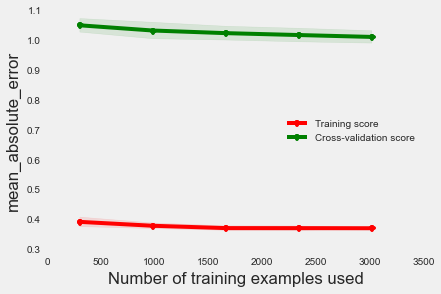

In [53]:
draw_learning_curve(RF_model, X_train, y_train, estimator_titles=['Learning Curve for RF. Best'], 
                    cv=cv, scoring=scoring);

In [54]:
results.loc['RF','lc_com'] = '.......'

In [55]:
# Get Mean Error of the test set
results.loc['RF','mean_abs_error'] = mean_absolute_error(y_test, RF_model.predict(X_test))
print 'Mean Absolute Error = ', results.loc['RF','mean_abs_error']   

Mean Absolute Error =  1.00570041816


In [56]:
results.loc['RF','R2_score'] = RF_model.score(X_test, y_test)
print 'Model R2_score : ', results.loc['RF','R2_score']

Model R2_score :  0.121813254266


In [57]:
# Check the Speed of esimator
time = %timeit -o RF_model.predict(X_test)
print time
results.loc['RF','time'] = time.best * 1000000

10 loops, best of 3: 15.9 ms per loop


## SVM


[[back to top](#Sections)]


In [58]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=0)

In [59]:
#SVM_model = SVR(C=10, kernel='rbf', gamma=.001, degree=1)
#SVM_model.fit(X_train_std, y_train)

In [60]:
#params = {'C': np.linspace(1, 7, 4), 'kernel': ['poly', 'rbf'],
#         'degree': range(1,3), 'gamma': np.linspace(.001, 10, 2)}
# 1 params = {'kernel': ['poly', 'rbf', ‘sigmoid’, ‘linear’], 'degree': range(1,4)}
params = {'C': np.linspace(.01, 3, 4), 'kernel': ['poly'], 'degree': range(1,4), 'gamma': np.linspace(.01, .03, 4)}
#params = {'gamma': np.linspace(.0001, .05, 4)}
#'gamma': [0.015]}

clf = SVR()
grid = GridSearchCV(clf, params, cv=cv, scoring=scoring, n_jobs=-1)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=ShuffleSplit(3777, n_iter=5, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'kernel': ['poly'], 'C': array([ 0.01   ,  1.00667,  2.00333,  3.     ]), 'gamma': array([ 0.01   ,  0.01667,  0.02333,  0.03   ]), 'degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_absolute_error', verbose=0)

In [61]:
grid.best_params_

{'C': 3.0, 'degree': 1, 'gamma': 0.029999999999999999, 'kernel': 'poly'}

In [62]:
#grid.grid_scores_

In [63]:
SVM_model = grid.best_estimator_

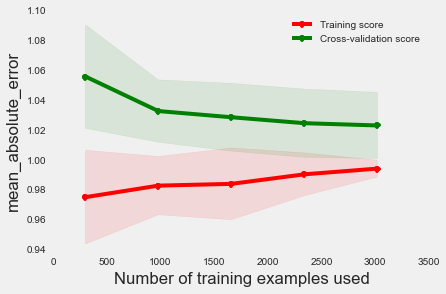

In [64]:
draw_learning_curve(SVM_model, X_train_std, y_train, estimator_titles=['Learning Curve for SVC. Best'], 
                    cv=cv, scoring=scoring);

In [65]:
results.loc['SVM','lc_com'] = '.......'

In [66]:
results.loc['SVM','R2_score'] = SVM_model.score(X_test_std, y_test)
print 'Model R2_score : ', results.loc['SVM','R2_score']

Model R2_score :  0.113868470107


In [67]:
# Get Mean Error of the test set
results.loc['SVM','mean_abs_error'] = mean_absolute_error(y_test, SVM_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['SVM','mean_abs_error']            

Mean Absolute Error =  1.00085293611


In [68]:
# Check the Speed of esimator
time = %timeit -o SVM_model.predict(X_test_std)
print time
results.loc['SVM','time'] = time.best * 1000000

10 loops, best of 3: 65.7 ms per loop


## Lasso/Ridge

[[back to top](#Sections)]


In [69]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train_std.shape[0], n_iter=20, test_size=0.2, random_state=0)

In [130]:
# using Mean Absolute scoring
parameters = {'alpha': np.linspace(.0001,1,20)}
LR = Lasso(normalize=False)
clf = GridSearchCV(LR, parameters, scoring=scoring, cv=cv)
clf.fit(X_train_std, y_train)
clf.best_params_

{'alpha': 0.0001}

In [131]:
LR_model = clf.best_estimator_

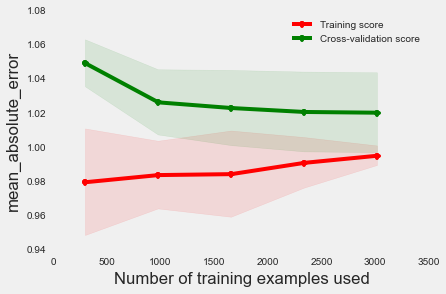

In [132]:
draw_learning_curve(LR_model, X_train_std, y_train, estimator_titles=['Learning Curve for lasso'], 
                    cv=cv, scoring=scoring);

In [125]:
results.loc['LR','lc_com'] = '.......'

In [126]:
results.loc['LR','R2_score'] = LR_model.score(X_test_std, y_test)
print 'Model R2_score : ', results.loc['LR','R2_score']

Model R2_score :  0.109749759218


In [127]:
# Get Mean Error of the test set
results.loc['LR','mean_abs_error'] = mean_absolute_error(y_test, LR_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['LR','mean_abs_error']             

Mean Absolute Error =  1.00400366418


In [128]:
# Check the Speed of esimator
time = %timeit -o LR_model.predict(X_test_std)
print time
results.loc['LR','time'] = time.best * 1000000

The slowest run took 12.37 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 40.2 µs per loop


In [129]:
# create a dataframe to show our coefficients
d = {'features': X_test.columns, 'coefficients': LR_model.coef_}
pd.DataFrame(d)

,coefficients,features
0,0.599154,temp_max
1,-0.860724,temp_mean
2,0.925738,temp_min
3,-0.043711,temp_delta
4,0.401793,dew_point_mean
5,-0.110222,humidity_mean
6,0.015151,sl_pressure_mean
7,0.599154,wind_chill_max
8,-0.860724,wind_chill_mean
9,0.009894,wind_speed_max


## knn

[[back to top](#Sections)]


In [78]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train_std.shape[0], n_iter=5, test_size=0.2, random_state=0)

In [79]:
# Can be any estimator
knn = KNeighborsRegressor()

In [80]:
# Run estimator for all parameter combinations
parameters = {'n_neighbors': range(1,10), 'weights': ['uniform', 'distance'],'p': range(1,4)}
#parameters = {'n_neighbors': range(1,20), 'weights': ['uniform', 'distance'],'p': range(1,4)}
clf = GridSearchCV(knn, parameters, cv=cv)
clf.fit(X_train_std, y_train)
clf.best_params_

{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [81]:
knn_model = clf.best_estimator_

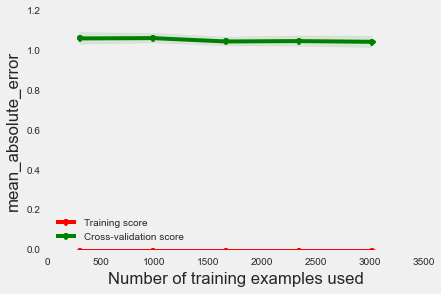

In [82]:
draw_learning_curve(knn_model, X_train_std, y_train, estimator_titles=['Learning Curve for knn'], 
                    cv=cv, scoring=scoring);

In [83]:
results.loc['knn','lc_com'] = '.......'

In [84]:
# Find out Score for actual data
results.loc['knn','R2_score'] = knn_model.score(X_test_std, y_test)
print 'Model R2_score : ', results.loc['knn','R2_score']

Model R2_score :  0.0639729612307


In [85]:
# Get Mean Error of the test set
results.loc['knn','mean_abs_error'] = mean_absolute_error(y_test, knn_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['knn','mean_abs_error']   

Mean Absolute Error =  1.04657293887


In [86]:
# Check the Speed of esimator
time = %timeit -o knn_model.predict(X_test_std)
print time
results.loc['knn','time'] = time.best * 1000000

10 loops, best of 3: 98.9 ms per loop


# Forecast

[[back to top](#Sections)]


## Data source for Forecast
Data was consolidated in Notebook
- This is done in the `'8_get_weather_forcast'` notebook. | Downloaded from Weather Underground and OpenWeatherMap
- Data is written to file. `'forecast_10day.csv'`


FieldName|Type|Description                             
---------------|------------|---------------------
Index:Date|DateTime|2003-01-01 to 2015-12-31
date|string|Format yyyy-m-d
dayofweek|object|Day of the week in string format
day|int64|Day of month in numeric
month|int64|Month of year in numeric
year|int64|Year in numeric
temp_max|int64|High Temperature for the day in degrees F
temp_mean|int64|Mean Temperature for the day in degrees F
temp_min|int64|Low Temperature for the day in degrees F
temp_delta|int64|Temperature change for the day in degrees F
sl_pressure_mean|float64|Mean Sea Level for the day in inches
humidity_mean|int64|Mean Humidity for the day in percentage
wind_speed_max|int64|Maximum maintained Wind Speed in mph
wind_speed_mean|int64|Mean maintained Wind Speed in mph
cloud_cover|int64|Cloud Cover in percentage.
precipitation|float64|Amount is precipitation in inches
events|object|Significant Events such as 'Rain', 'Fog'
wind_direction|int64|General wind direction, numeric 0 359
dew_point_mean|int64|Mean Dewpoint for day on day
sun_length|float64|Number of minutes of Sun on day
moon_phase|float64|Phase moon is in. 0.5 = full moon
sun_units|float64|the minutes of Sun scaled by the cloud cover percentage
rain|bool| IS there rain in the forcast
end_of_week|bool|is it Friday or Saturday

In [87]:
forecast = pd.read_csv('forecast_10day.csv', index_col=0)
forecast



,date,dayofweek,day,month,year,temp_max,temp_mean,temp_min,temp_delta,sl_pressure_mean,...,end_of_week,rain,sun_length,moon_phase,sun_units,dew_point_mean,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
0,2016-2-29,monday,29,2,2016,74,64,54,20,30.324062,...,False,False,682.266667,0.704623,436.650667,55.059697,64,74,245.780802,111.154247
1,2016-3-1,tuesday,1,3,2016,66,59,52,14,30.295418,...,False,False,684.650000,0.738557,684.650000,50.041066,59,66,194.294110,88.604228
2,2016-3-2,wednesday,2,3,2016,65,60,55,10,30.253190,...,False,False,687.016667,0.772491,604.574667,53.916106,60,65,238.543985,95.979855
3,2016-3-3,thursday,3,3,2016,63,58,53,10,30.330263,...,False,True,689.416667,0.806424,55.153333,51.164585,58,63,207.678601,92.720995
4,2016-3-4,friday,4,3,2016,63,59,56,7,29.961729,...,True,True,691.783333,0.840358,172.945833,51.543547,59,63,210.765965,93.127630
5,2016-3-5,saturday,5,3,2016,64,59,54,10,29.929246,...,True,True,694.183333,0.874292,104.127500,53.499108,59,64,234.994865,87.000394
6,2016-3-6,sunday,6,3,2016,60,55,51,9,29.655207,...,False,True,696.566667,0.908226,6.965667,47.455484,55,60,171.281888,74.777254
7,2016-3-7,monday,7,3,2016,59,55,51,8,29.687985,...,False,True,698.983333,0.942160,671.024000,46.577691,55,59,163.184754,76.026069
8,2016-3-8,tuesday,8,3,2016,60,56,52,8,29.903850,...,False,True,701.366667,0.976093,448.874667,48.975407,56,60,185.760726,80.706963
9,2016-3-9,wednesday,9,3,2016,61,57,53,8,29.918910,...,False,True,703.783333,1.010027,302.626833,50.764531,57,61,204.336450,86.683367


In [88]:
forecast.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 28 columns):
date                10 non-null object
dayofweek           10 non-null object
day                 10 non-null int64
month               10 non-null int64
year                10 non-null int64
temp_max            10 non-null int64
temp_mean           10 non-null int64
temp_min            10 non-null int64
temp_delta          10 non-null int64
sl_pressure_mean    10 non-null float64
humidity_mean       10 non-null int64
wind_speed_max      10 non-null int64
wind_speed_mean     10 non-null int64
cloud_cover         10 non-null int64
precipitation       10 non-null float64
events              10 non-null object
wind_direction      10 non-null int64
owm_status          10 non-null object
end_of_week         10 non-null bool
rain                10 non-null bool
sun_length          10 non-null float64
moon_phase          10 non-null float64
sun_units           10 non-null float64
dew_point_me

## Add Engineered Features

[[back to top](#Sections)]


In [89]:
#data['events'].fillna('No', inplace=True)
forecast['events'] = forecast['events'].astype('category')
forecast['day'] = forecast['day'].astype('category')
forecast['month'] = forecast['month'].astype('category')
forecast['year'] = forecast['year'].astype('category')
forecast['dayofweek'] = forecast['dayofweek'].astype('category')
forecast['end_of_week'] = forecast['end_of_week'].astype('category')
forecast['rain'] = forecast['rain'].astype('category')



In [90]:
forecast2 = forecast[features]
forecast2.head()

,temp_max,temp_mean,temp_min,temp_delta,dew_point_mean,humidity_mean,sl_pressure_mean,wind_chill_max,wind_chill_mean,wind_speed_max,...,precipitation,cloud_cover,wind_direction,sun_length,moon_phase,sun_units,end_of_week,rain,temp_apparent,heat_index
0,74,64,54,20,55.059697,66,30.324062,74,64,9,...,0.00,36,54,682.266667,0.704623,436.650667,False,False,111.154247,245.780802
1,66,59,52,14,50.041066,65,30.295418,66,59,15,...,0.00,0,258,684.650000,0.738557,684.650000,False,False,88.604228,194.294110
2,65,60,55,10,53.916106,75,30.253190,65,60,20,...,0.24,12,210,687.016667,0.772491,604.574667,False,False,95.979855,238.543985
3,63,58,53,10,51.164585,72,30.330263,63,58,10,...,0.01,92,230,689.416667,0.806424,55.153333,False,True,92.720995,207.678601
4,63,59,56,7,51.543547,70,29.961729,63,59,10,...,0.17,75,176,691.783333,0.840358,172.945833,True,True,93.127630,210.765965


In [91]:
# use get_dummies to convert categoricals into binary features
#forecast2 = pd.get_dummies(forecast2)
#forecast2.head(2)

In [92]:
# Drop one feature for each categorical
# drop on day of week
#forecast2.drop(dummy_drop, axis=1, inplace=True)
#forecast2.head(2)

In [93]:
print 'Do the two Datasets have matching Features? : ', list(X) == list(forecast2)

Do the two Datasets have matching Features? :  True


In [94]:
prediction = forecast[['dayofweek', 'month', 'day','year', 'temp_max']]

In [95]:
forecast2_std = stdsc.transform(forecast2)

### Run Models on Prediction

[[back to top](#Sections)]


In [96]:
prediction.loc[:,'prediction (dummy)'] = dummy_model.predict(forecast2_std)
prediction.loc[:,'prediction (RF)'] = RF_model.predict(forecast2)
prediction.loc[:,'prediction (SVM)'] = SVM_model.predict(forecast2_std)
prediction.loc[:,'prediction (LR)'] = LR_model.predict(forecast2_std)
prediction.loc[:,'prediction (knn)'] = knn_model.predict(forecast2_std)
prediction

/Users/jsmithson/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jsmithson/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,dayofweek,month,day,year,temp_max,prediction (dummy),prediction (RF),prediction (SVM),prediction (LR),prediction (knn)
0,monday,2,29,2016,74,4.633704,4.782056,4.702432,4.837893,4.854195
1,tuesday,3,1,2016,66,4.633704,4.753629,4.780502,4.706091,4.132211
2,wednesday,3,2,2016,65,4.633704,4.760484,4.715349,4.664000,4.450975
3,thursday,3,3,2016,63,4.633704,3.823992,4.271382,4.319673,4.462999
4,friday,3,4,2016,63,4.633704,4.463508,5.070351,4.998841,4.904007
5,saturday,3,5,2016,64,4.633704,5.082258,4.255294,4.124384,5.088989
6,sunday,3,6,2016,60,4.633704,3.705645,3.583295,3.439879,4.012479
7,monday,3,7,2016,59,4.633704,4.989315,4.333732,4.143855,4.599753
8,tuesday,3,8,2016,60,4.633704,4.335081,4.227916,4.098646,4.433639
9,wednesday,3,9,2016,61,4.633704,4.041532,3.970212,3.867570,4.424497


## Results

[[back to top](#Sections)]


In [97]:
results



,mean_abs_error,R2_score,time,lc_com
dummy,1.06292,-0.00271301,36.4885,NaN
RF,1.0057,0.121813,15891.8,.......
SVM,1.00085,0.113868,65685.3,.......
LR,1.00331,0.114029,43.4563,.......
knn,1.04657,0.063973,98906.6,.......


### Minimum features

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|--------    
dummy	|0.784282	|-0.000157419	|61.39	|NaN
RF	|0.774239	|0.0257063|	22676.5|	.......
SVM	|0.750965|	0.0731648	|66745.8	|.......
LR	|0.751183|	0.0763004	|52.1146	|.......
knn|	0.790226|	-0.00414537|	56354.1	|.......

### ADD in day of week

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|--------    
dummy	|0.784282	|-0.000157419|	54.2332	|NaN
RF|	0.719557	|0.134418	|30144.3	|.......
SVM|	0.706	|0.160249|	80992.5	|.......
LR	|0.702858|	0.167961	|59.3654	|.......
knn	|0.738919	|0.102316	|581535	|.......

### Run with weather_crime_level

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|-------- |
dummy|	0.81541|	-0.000657135	|31.7786	|NaN
RF	|0.762109|	0.11542	|19874.3	|.......
SVM	|0.742392|	0.140592	|42451	|.......
LR	|0.742925|	0.142355	|36.54	|.......
knn	|0.770477|	0.0884748	|401028|	.......

### Run with a few outliers removed

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|-------- |
dummy|	0.909594|	-0.00158336|	31.9462	|NaN
RF|	0.862721|	0.0884625	|19899.5|	.......
SVM|	0.834469|	0.138694|	42997.6	|.......
LR|	0.8343	|0.142013	|36.0181	|.......
knn|	0.884176|	0.0519649|	61164.6	|.......

### Put in all non cat features - wind gust

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|-------- |
dummy|	1.06292	|-0.00271301	|39.1949	|NaN
RF	|0.983553	|0.148392	|18754.8	|.......
SVM|	0.970188	|0.16634	|88509.3	|.......
LR	|0.976822	|0.161785	|51.1119	|.......
knn	|1.02312|	0.0997018	|145841	|.......

### Put in 'end_of_week' / 'rain' booleans ans the dew_point_mean

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|-------- |
dummy	|1.06292	|-0.00271301|	35.1662	|NaN
RF	|0.995831	|0.132448	|25175.8	|.......
SVM	|1.00083	|0.115296	|52742	|.......
LR	|1.00426	|0.113532	|40.5828	|.......
knn	|1.04523	|0.0641483	|89629.6	|.......

### add in wind chill, heat index, apparent temp

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|-------- |
dummy	|1.06292	|-0.00271301|	36.4885	|NaN
RF|	1.0057	|0.121813	|15891.8	|.......
SVM	|1.00085	|0.113868	|65685.3	|.......
LR	|1.00331	|0.114029	|43.4563	|.......
knn|	1.04657|	0.063973	|98906.6	|.......

# Change Log

[[back to top](#Sections)]


### Ran with all features
Had problems running
### Took Minimum features
Got scores for 4 models. All not much better than dummy
### Add in day of week dummies - Left all six features in
Better scores
### Added the weather_crime index - Ran tests
Went back and tried to pick the type of crimes that I thought were weather related. Ran with that number as label.
- Scores were similar to last run. Dummy MAE was slightly higher. Best R2 scores .14 (SVM LR)

### Removed a few of the outliers - reran
- Scores went down slightly - LR similar - knn rf drop most

### Add in all non cat features - wind gust
- Scores back up to .16. Same as when just added in day of week.

### replaced day of week dummies with end_of_week bool, added 'rain and 'dewPoint_mean,
- Scores drop 5% knn big drop

## To Try

[[back to top](#Sections)]


- remove outliers (Christmas) - Done because I am concerned with how weather effects crime. Xmas is special non weather related event. Also not interested in predictiong black swans. Outliers may skew models.
- add in the rest of the features
- Make catagoricals into smaller groupings. add in day of month. Rain or not rain/for thunder
- remove worst performers
- use only the last few years data.
- Use bag of words to classify crime as weather/emotional related.